In [22]:
import sys, logging, datetime

sys.stdout = open("/home/ailabguest/alessandrodileone/SVM_log/CV_SVM_RBF", "w")

logging.basicConfig(filename='/home/ailabguest/alessandrodileone/SVM_log/CV_SVM_RBF.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [1]:
import pandas as pd
tweets = pd.read_csv("/home/ailabguest/alessandrodileone/dataset_sentiment/train.csv", encoding='latin-1')
list(tweets.columns.values)

tweets.Sentiment.replace(0,'negative', inplace=True)
tweets.Sentiment.replace(1,'positive', inplace=True)

In [2]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [3]:
tweets['normalized_tweet'] = tweets.SentimentText.apply(normalizer)

In [4]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet.apply(ngrams)

In [5]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [6]:
vectorized_data = count_vectorizer.fit_transform(tweets.SentimentText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [7]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = tweets.Sentiment.apply(sentiment2target)

In [8]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.3, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
print( datetime.datetime.now(), ' : CVCrossGrid Started')

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.4, random_state=42)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)
grid.fit(data_train, targets_train)

print( datetime.datetime.now(), ' : CVCrossGrid Done')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 242.0min


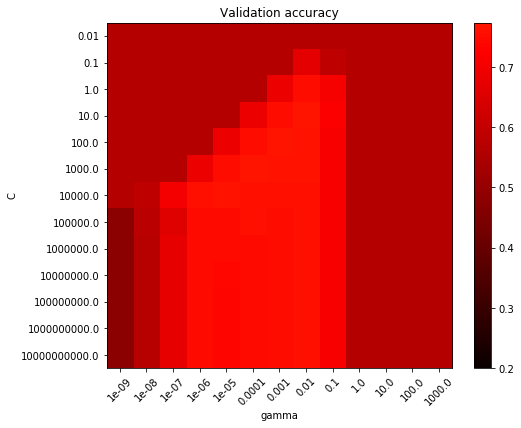

In [15]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt 

# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.savefig(fname="SVM_heatmap.png")
plt.show()

In [11]:
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {"C": 10.0, "gamma": 0.01} with a score of 0.77


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

clf = OneVsRestClassifier(svm.SVC(C=10.0, kernel='rbf', gamma=0.01, verbose=2, probability=True), n_jobs=-1)
clf_output = clf.fit(data_train, targets_train)

In [27]:
clf

OneVsRestClassifier(estimator=SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=2),
          n_jobs=-1)

In [21]:
clf.score(data_test, targets_test)

0.7827782778277828

In [28]:
se = count_vectorizer.transform(["Trump is the worst president ever, but the sun is still awesome!"])
clf.predict_proba(se)

array([[0.75702126, 0.24297874]])

In [29]:
se = count_vectorizer.transform(["Trump is the worst president ever"])
clf.predict_proba(se)

array([[0.82408381, 0.17591619]])

In [30]:
se = count_vectorizer.transform(["Trump is the best president ever"])
clf.predict_proba(se)

array([[0.22238346, 0.77761654]])

In [36]:
se = count_vectorizer.transform(["Sun is awesome"])
clf.predict_proba(se)

array([[0.09207318, 0.90792682]])

In [37]:
import tweepy
from pymongo import MongoClient


df = pd.read_csv('authority-modularity.csv')
df=df.drop(['Label','timeset','Hub'],axis=1)

indexNames = df[ (df.modularity_class != 11) & (df.modularity_class != 9) & (df.modularity_class != 4) ].index
df.drop(indexNames , inplace=True)

df.modularity_class.value_counts()

first10_cl11=df[df.modularity_class == 11].sort_values('Authority', ascending=False).head(10)
first10_cl4=df[df.modularity_class == 4].sort_values('Authority', ascending=False).head(10)
first10_cl9=df[df.modularity_class == 9].sort_values('Authority', ascending=False).head(10)

utenti_cl11=first10_cl11.Id.tolist()
utenti_cl4=first10_cl4.Id.tolist()
utenti_cl9=first10_cl9.Id.tolist()

utenti_final= utenti_cl11+utenti_cl4+utenti_cl9


ACCESS_TOKEN = '1089903781880434688-SDhXR2aBBr54lZQ8QnPaE4mUR6TrOd'
ACCESS_SECRET = 'D6wHvFEmbL3W0FSP70jxBRpIYs53UGxuQlQ5yHf578ZDt'
CONSUMER_KEY = 'kGR5GYd09tSmQCJeyprOKlKeV'
CONSUMER_SECRET = 'MNeyyl0SkUOGgkIs8kDdZktPi2HCxC7mTv6re4GywsiarZDR3c'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET) 
  
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET) 

api = tweepy.API(auth)


from datetime import timedelta, datetime

for idx, utente in enumerate(utenti_final):
    try:
        last_tweet = api.user_timeline(user_id=utente, count=1) 
        created_at = last_tweet[0].created_at
    
        if (created_at > datetime.now() - timedelta(days=90)):
            print('{}: this user is still active: {}\tlast post: {}'.format(idx,utente,created_at))
        else:
            utenti_final.remove(utente)
            print('inactive user {} droppato'.format(utente))
                
    except Exception as err:
        print(err)
        utenti_final.remove(utente)
        print('inactive user {} droppato'.format(utente))
        continue
        
        
client = MongoClient('localhost', 27017)
db = client['twitter']

data = pd.DataFrame(columns=['Tweets'])

for user in utenti_final:
    
    print('colleziono tweet utente numero:', user)

    pipeline=[{ "$project": {  "id_user" : 1, "originalTweet" : 1, "hashtag" : 1, "mention" : 1}}, { "$match": {  "id_user" : user} }]

    cursor_list = list(db['tweets'].aggregate(pipeline))

    tweets = pd.DataFrame(cursor_list)
    data=data.append(tweets, sort=True)

dfAll = pd.DataFrame(data.originalTweet)

Not authorized.
inactive user 123926189 droppato
1: this user is still active: 52456063	last post: 2019-10-03 12:19:23
2: this user is still active: 18119568	last post: 2019-10-03 09:03:15
3: this user is still active: 14872161	last post: 2019-10-03 06:24:21
4: this user is still active: 10236782	last post: 2019-10-03 11:58:40
5: this user is still active: 45762728	last post: 2019-09-24 01:07:11
6: this user is still active: 175339579	last post: 2019-10-03 11:58:50
7: this user is still active: 171656520	last post: 2019-10-03 07:51:04
8: this user is still active: 21765964	last post: 2019-09-24 20:02:45
Not authorized.
inactive user 15773072 droppato
inactive user 42919671 droppato
11: this user is still active: 54292369	last post: 2019-10-03 02:57:10
12: this user is still active: 18084838	last post: 2019-10-03 05:28:30
13: this user is still active: 41823835	last post: 2019-10-03 07:25:01
14: this user is still active: 94853291	last post: 2019-10-03 00:29:01
15: this user is still ac

In [38]:
trumpTweet = dfAll[dfAll.originalTweet.str.contains("(?:^|\W)#Trump(?:$|\W)|\
                                                (?:^|\W)#DonaldTrump(?:$|\W)|\
                                                (?:^|\W)#trump(?:$|\W)|\
                                                (?:^|\W)@realDonaldTrump(?:$|\W)\
                                                (?:^|\W)#donaldtrump(?:$|\W)\
                                                (?:^|\W)Trump(?:$|\W)|\
                                                (?:^|\W)DonaldTrump(?:$|\W)|\
                                                (?:^|\W)trump(?:$|\W)|\
                                                (?:^|\W)realDonaldTrump(?:$|\W)\
                                                (?:^|\W)donaldtrump(?:$|\W)")]

In [39]:
trumpTweet['originalTweet'] = trumpTweet['originalTweet'].apply(lambda x: x.lower())
trumpTweet['originalTweet'] = trumpTweet['originalTweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

for idx,row in trumpTweet.iterrows():
    row[0] = row[0].replace('rt',' ')

/home/ailabguest/anaconda3/envs/py36guest/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ailabguest/anaconda3/envs/py36guest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
counts = {}
counts['positive']=0
counts['negative']=0


for twt in trumpTweet.originalTweet:

    twt = [twt]
    twt = count_vectorizer.transform(twt)
    sentiment = clf.predict_proba(twt)
    
    if sentiment[0][0] <= sentiment[0][1]:
        counts["positive"]+=1
    else:
        counts["negative"]+=1

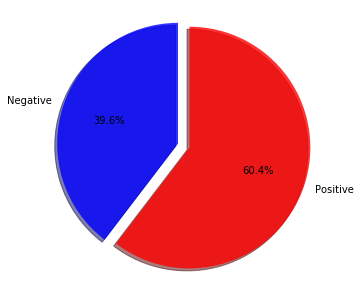

In [42]:
import matplotlib
import matplotlib.pyplot as plt

sizes = [counts['negative'], counts['positive']]
explode = (0, 0.1)
labels = 'Negative', 'Positive'
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="br", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()